In [1]:
import json
from data_preparation import prepro_data_gp, prepro_data_pce, prepro_data_kl, preprocess_field_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np

import openturns as ot
import matplotlib.pyplot as plt
from metamodels import GpMetamodel, VPCEMetamodel, KarhunenLoeveMetamodel
from plot import plot_tpd
import pickle

BASE_DIRECTORY = '/Users/edgarjaber/Desktop/Articles/codes folder/Bayes-calibration-for-clogging-prognostics/DATA/'
SIMULATION_TIME = np.load(BASE_DIRECTORY + 'simulation_data/LHS/t_gv.npy', allow_pickle=True)

csv_file = BASE_DIRECTORY + 'field_data/field_data.csv'
input_dic = json.load(open(BASE_DIRECTORY + 'meta_data/SG_cleaning_conditioning.json'))
cleaning_dates = [input_dic['chemistry']['cleaning'][i]['time']/24 for i in range(len(input_dic['chemistry']['cleaning']))]

HOURLY_GRID = np.linspace(0, 420481, 420481).astype(int)

# GP metamodel build

In [2]:
TREND = 'Quad'
COV = 'AbsExp'

In [3]:
### DATA ###
lhs_hl = np.load(BASE_DIRECTORY + 'simulation_data/LHS/doe_hl.npy', allow_pickle=True)
lhs_cl = np.load(BASE_DIRECTORY + 'simulation_data/LHS/doe_cl.npy', allow_pickle=True)

mc_hl = np.load(BASE_DIRECTORY + 'simulation_data/MC/doe_hl.npy', allow_pickle=True)
mc_cl = np.load(BASE_DIRECTORY + 'simulation_data/MC/doe_cl.npy', allow_pickle=True)


## For the LHS DoE

In [4]:
n_max = lhs_hl.shape[0]
n_samp = 1000
dimension = 2

In [5]:
X, y, scaler = prepro_data_gp(lhs_hl, lhs_cl, SIMULATION_TIME, n_max, n_samp, dimension, scale=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

In [7]:
GP = GpMetamodel(trend=TREND, kernel=COV, dimension=dimension)

In [8]:
GP.fit(X_train, y_train)

WRN - Warning! For coherency we set scale upper bounds = [6.94659,6.88956]


In [9]:
y_pred = GP.predict(X_test)
print(f'R2 = {r2_score(y_test, y_pred)}')

R2 = 0.9915884013802161


In [10]:
X, y = prepro_data_gp(lhs_hl, lhs_cl, SIMULATION_TIME, n_max, n_samp, dimension, scale=False)
_, X_test, _, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

real_test = []
for l in range(X_test.shape[0]):
    rand_test = []
    for q in range(0, len(SIMULATION_TIME)):
         rand_test.append(list(X_test[l, :dimension-1]) + [SIMULATION_TIME[q]*24])
    real_test.append(rand_test)
real_test = np.array(real_test)

In [11]:
pred_traj = []
for l in range(X_test.shape[0]):
    scaled_test = scaler.transform(real_test[l,:,:])
    pred_traj.append(GP.predict(scaled_test))

Text(0.5, 0.98, 'GP metamodel, Quad trend, AbsExp kernel')

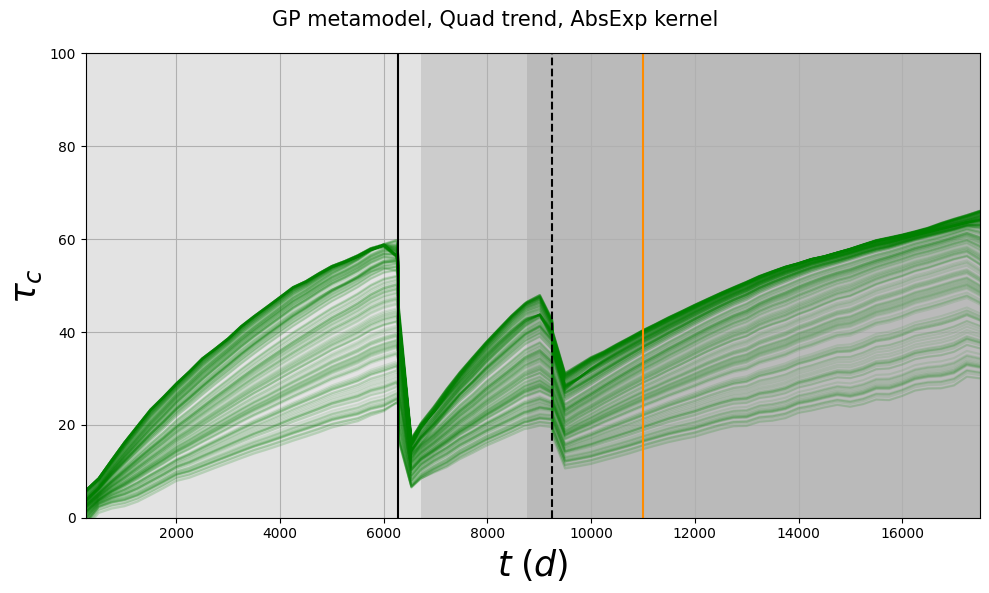

In [12]:
fig, axs = plot_tpd(input_dic, np.asarray(pred_traj), SIMULATION_TIME, 'GP metamodel')
fig.suptitle('GP metamodel, Quad trend, AbsExp kernel', fontsize=15)

In [13]:
with open(BASE_DIRECTORY + f'metamodels/GP/gp_{TREND}_{COV}_lhs.pkl', 'wb') as f:
    pickle.dump(GP, f) # :D gp.gp

with open(BASE_DIRECTORY + f'metamodels/GP/gp_{TREND}_{COV}_lhs_scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

## For the MC DoE

In [14]:
X, y, scaler = prepro_data_gp(mc_hl, mc_cl, SIMULATION_TIME, n_max, n_samp, dimension, scale=True)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

In [16]:
GP = GpMetamodel(trend=TREND, kernel=COV, dimension=dimension)

In [17]:
GP.fit(X_train, y_train)

WRN - Warning! For coherency we set scale upper bounds = [6.86092,6.80553]


In [18]:
y_pred = GP.predict(X_test)
print(f'R2 = {r2_score(y_test, y_pred)}')

R2 = 0.9987270601494765


In [19]:
X, y = prepro_data_gp(lhs_hl, lhs_cl, SIMULATION_TIME, n_max, n_samp, dimension, scale=False)
_, X_test, _, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

real_test = []
for l in range(X_test.shape[0]):
    rand_test = []
    for q in range(0, len(SIMULATION_TIME)):
         rand_test.append(list(X_test[l, :dimension-1]) + [SIMULATION_TIME[q]*24])
    real_test.append(rand_test)
real_test = np.array(real_test)

In [20]:
pred_traj = []
for l in range(X_test.shape[0]):
    scaled_test = scaler.transform(real_test[l,:,:])
    pred_traj.append(GP.predict(scaled_test))

Text(0.5, 0.98, 'GP metamodel, Quad trend, AbsExp kernel')

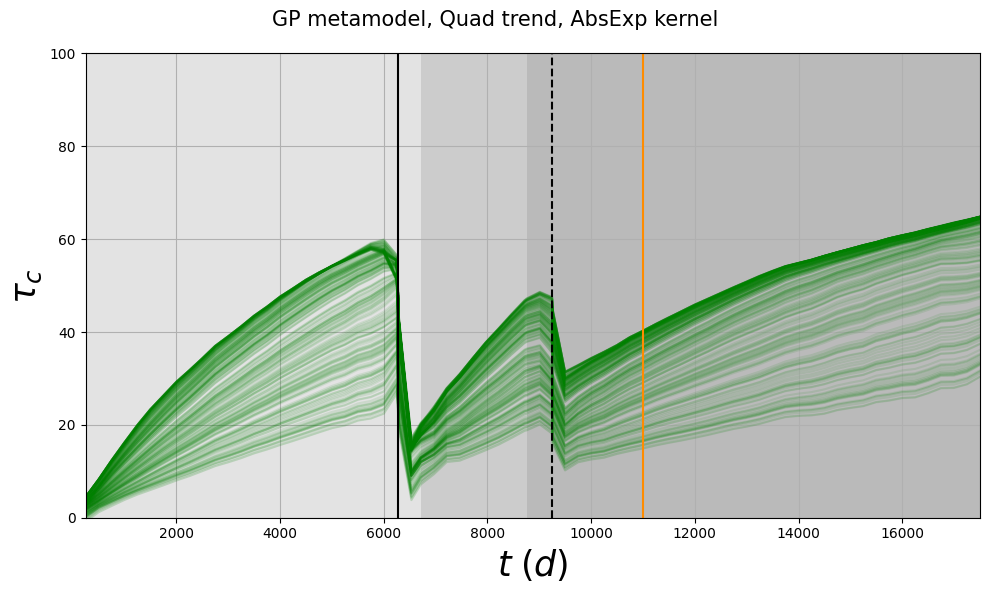

In [21]:
fig, axs = plot_tpd(input_dic, np.asarray(pred_traj), SIMULATION_TIME, 'GP metamodel')
fig.suptitle('GP metamodel, Quad trend, AbsExp kernel', fontsize=15)

In [22]:
with open(BASE_DIRECTORY + f'metamodels/GP/gp_{TREND}_{COV}_mc.pkl', 'wb') as f:
    pickle.dump(GP, f) # :D gp.gp

with open(BASE_DIRECTORY + f'metamodels/GP/gp_{TREND}_{COV}_mc_scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

# PCE metamodel

In [23]:
data, time_indices = preprocess_field_data(csv_file=csv_file, 
                                           operation_time=SIMULATION_TIME, 
                                           cleaning_dates=cleaning_dates, 
                                           with_time_division=False)


distribution = ot.Uniform(0, 15e-4)
prior_distribution_list = [distribution]

DEGREE=5
QNORM = 0.7
 

## For the LHS DoE

In [4]:
X, y = prepro_data_pce(lhs_hl, lhs_cl, n_max, n_samp, dimension)

NameError: name 'n_max' is not defined

In [25]:
y_interpolated = np.asarray([np.interp(data[:,0]*24, SIMULATION_TIME*24, y[i,:]) for i in range(len(y))])

In [26]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X, y_interpolated, train_size=0.75, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

In [27]:
PCE_calibration = VPCEMetamodel(degree=DEGREE, q_norm=QNORM, prior=ot.Uniform(0.0, 15e-4))
PCE_full = VPCEMetamodel(degree=DEGREE, q_norm=QNORM, prior=ot.Uniform(0.0, 15e-4))

In [28]:
PCE_calibration.fit(X_train, y_train_int)
PCE_full.fit(X_train, y_train)

Running Polynomial Chaos Expansion with regression method for degree 5, q-norm 0.7
Running Polynomial Chaos Expansion with regression method for degree 5, q-norm 0.7


WRN - set the component 58 of contributor 3=0 to zero as it is too small
WRN - set the component 4 of contributor 4=0 to zero as it is too small
WRN - set the component 62 of contributor 4=0 to zero as it is too small
WRN - set the component 79 of contributor 4=0 to zero as it is too small
WRN - set the component 80 of contributor 4=0 to zero as it is too small
WRN - set the component 48 of contributor 5=0 to zero as it is too small
WRN - set the component 89 of contributor 5=0 to zero as it is too small
WRN - set the component 25 of contributor 3=0 to zero as it is too small
WRN - set the component 28 of contributor 4=0 to zero as it is too small
WRN - set the component 72 of contributor 4=0 to zero as it is too small
WRN - set the component 73 of contributor 4=0 to zero as it is too small
WRN - set the component 74 of contributor 4=0 to zero as it is too small
WRN - set the component 21 of contributor 5=0 to zero as it is too small
WRN - set the component 42 of contributor 5=0 to zer

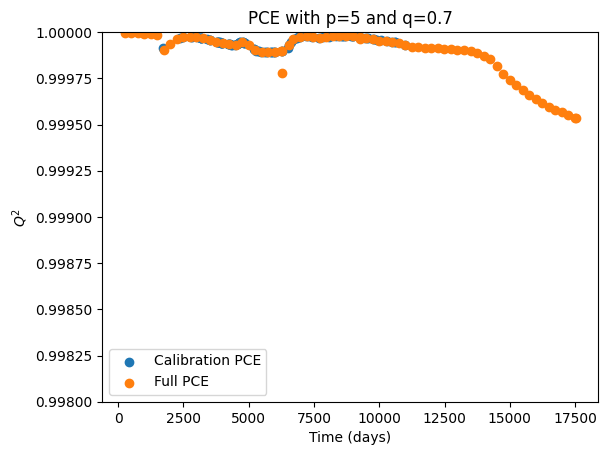

In [32]:
plt.scatter(data[:,0], PCE_calibration.r2_score(X_test, y_test_int, data[:, 0]), label='Calibration PCE')
plt.scatter(SIMULATION_TIME, PCE_full.r2_score(X_test, y_test, SIMULATION_TIME), label='Full PCE')
plt.ylim(0.998, 1)
plt.xlabel('Time (days)')
plt.ylabel(r'$Q^2$')
plt.title(f'PCE with p={DEGREE} and q={QNORM}')
plt.legend()

In [33]:
test_traj_calibration = PCE_calibration.predict(X_test)
test_traj_full = PCE_full.predict(X_test)

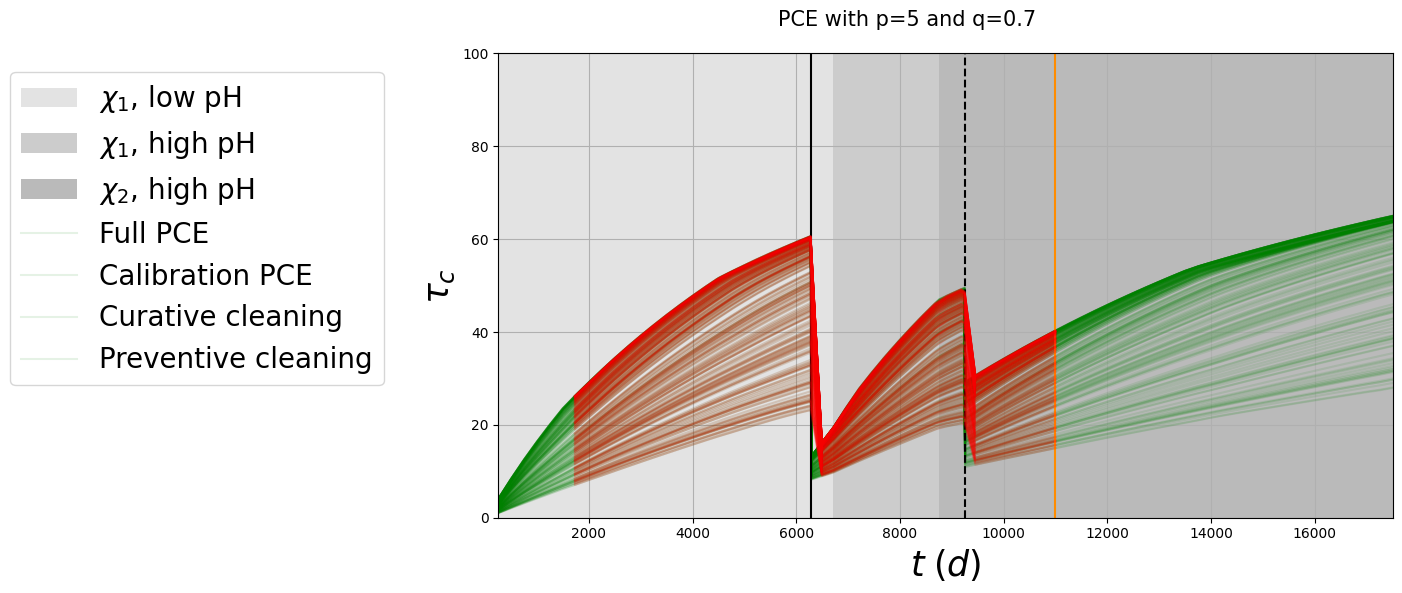

In [34]:
fig, axs = plot_tpd(input_dic, np.asarray(test_traj_full), SIMULATION_TIME, 'PCE metamodel')

for i in range(250):
    plt.plot(data[:,0], test_traj_calibration[i], color='red', alpha=0.1)
    if i == 0:
        plt.plot(data[:,0], test_traj_calibration[i], color='red', alpha=0.1, label='Calibration PCE')
fig.suptitle(f'PCE with p={DEGREE} and q={QNORM}', fontsize=15)
legend = [r'$\chi_1$, low pH', r'$\chi_1$, high pH', r'$\chi_2$, high pH', 'Full PCE', 'Calibration PCE', 'Curative cleaning', 'Preventive cleaning']
fig.legend(legend, bbox_to_anchor=(-0.01,0.9), fontsize=20)

In [35]:
with open(BASE_DIRECTORY + f'metamodels/PCE/PCE_cal_{DEGREE}_0{str(QNORM)[2]}_mc.pkl', 'wb') as f:
    pickle.dump(PCE_calibration, f) 

with open(BASE_DIRECTORY + f'metamodels/PCE/PCE_full_{DEGREE}_0{str(QNORM)[2]}_mc.pkl', 'wb') as f:
    pickle.dump(PCE_full, f)

# Karhunen-Loeve-based metamodel

In [5]:
data, time_indices = preprocess_field_data(csv_file=csv_file, 
                                           operation_time=SIMULATION_TIME, 
                                           cleaning_dates=cleaning_dates, 
                                           with_time_division=False)


In [6]:
X, y, scaler = prepro_data_kl(lhs_hl, lhs_cl, n_max, n_samp, dimension, scale=True)

0 nan trajectories in output sample


In [7]:
y_interpolated = np.asarray([np.interp(data[:,0]*24, SIMULATION_TIME*24, y[i,:]) for i in range(len(y))])

In [8]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X, y_interpolated, train_size=0.75, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

In [9]:
KL_calibration = KarhunenLoeveMetamodel(trend=TREND, kernel=COV, simulation_time=data[:,0]*24)
KL_full = KarhunenLoeveMetamodel(trend=TREND, kernel=COV, simulation_time=SIMULATION_TIME*24)

In [10]:
KL_calibration.fit(X_train, y_train_int)

Running Karhunen-Loeve decomposition
Explained variance for 1 modes is 0.9999862015633829
Done fitting mode 1


WRN - Warning! For coherency we set scale upper bounds = [6.94659]


In [19]:
gp_pred = np.asarray([KL_calibration.all_gps[i].predict(X_test) for i in range(KL_calibration.kl_result.nb_modes)])

In [20]:
(gp_pred[0,:].ravel()*np.ones((KL_calibration.kl_result.time_discretization, 1)))

array([[4.76632675, 4.94355571, 4.96635154, ..., 2.07804549, 4.96590589,
        3.88142424],
       [4.76632675, 4.94355571, 4.96635154, ..., 2.07804549, 4.96590589,
        3.88142424],
       [4.76632675, 4.94355571, 4.96635154, ..., 2.07804549, 4.96590589,
        3.88142424],
       ...,
       [4.76632675, 4.94355571, 4.96635154, ..., 2.07804549, 4.96590589,
        3.88142424],
       [4.76632675, 4.94355571, 4.96635154, ..., 2.07804549, 4.96590589,
        3.88142424],
       [4.76632675, 4.94355571, 4.96635154, ..., 2.07804549, 4.96590589,
        3.88142424]], shape=(98, 250))

In [21]:
np.dot([((gp_pred[i,:].ravel()*np.ones((KL_calibration.kl_result.time_discretization, 1))).T), KL_calibration.kl_result.modes[:KL_calibration.kl_result.nb_modes, :][0,:] for i in range(X_test.shape[0])])

SyntaxError: did you forget parentheses around the comprehension target? (2710462360.py, line 1)

In [22]:
np.asarray([np.dot(gp_pred[i,:].ravel()*np.ones((KL_calibration.kl_result.time_discretization, 1)),
                                         KL_calibration.modes[:KL_calibration.kl_result.nb_modes, :])[0,:] for i in range(X_test.shape[0])])

ValueError: shapes (98,250) and (1,98) not aligned: 250 (dim 1) != 1 (dim 0)

In [23]:
KL_calibration.kl_result.modes.shape

(1, 98)

In [24]:
KL_calibration.predict(X_test)

ValueError: shapes (98,250) and (1,98) not aligned: 250 (dim 1) != 1 (dim 0)